In [1]:
import cf_xarray # use cf-xarray so that we can use CF attributes
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import nc_time_axis
import numpy as np

import xarray as xr
import regionmask
import scienceplots
from glob import glob
import os
plt.style.use(["science", "nature"])
%matplotlib inline

from importlib import reload

## Read in datafiles and mask

In [2]:
# states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
# # Hawaii and Alaska are not included in the mask
# good_keys = [
#     k for k in states.regions.keys() 
#     if k not in states.map_keys(['Hawaii', 'Alaska'])
# ]
files = glob(os.getcwd()+'/data/*.nc')
cesm2 = {}
for f in files:
    # Open the dataset
    ds = xr.load_dataset(f).squeeze()
    # ds = ds.convert_calendar("noleap")
    # Mask the dataset
    # ds = ds.where(states.mask(ds.lon, ds.lat).isin(good_keys), drop=True)
    # For '/glade/u/home/valencig/wind-trend-analysis/ScenarioMIP.NCAR.CESM2.ssp370.day.gn.mean.nc'
    # Key will be ssp370.mean
    key1 = f.split('/')[-1].split('.')[-5]
    key2 = f.split('/')[-1].split('.')[-2]
    cesm2[key1+'.'+key2] = ds
cesm2.keys()

dict_keys(['ssp126.anomaly', 'ssp370.mean', 'ssp245.mean', 'ssp585.anomaly', 'ssp126.mean', 'ssp585.mean', 'ssp245.anomaly', 'historical.mean', 'ssp370.anomaly', 'historical.anomaly'])

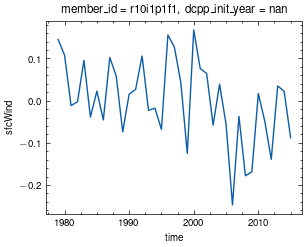

In [3]:
cesm2['historical.anomaly'].sfcWind.mean(['lat', 'lon']).plot()

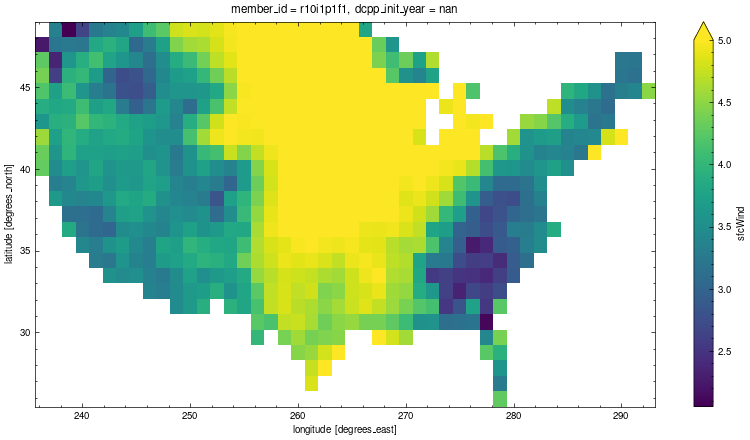

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
cesm2['historical.mean'].sfcWind.isel(time=slice(None, -1)).mean('time').plot(ax=ax, vmax=5)
plt.show()

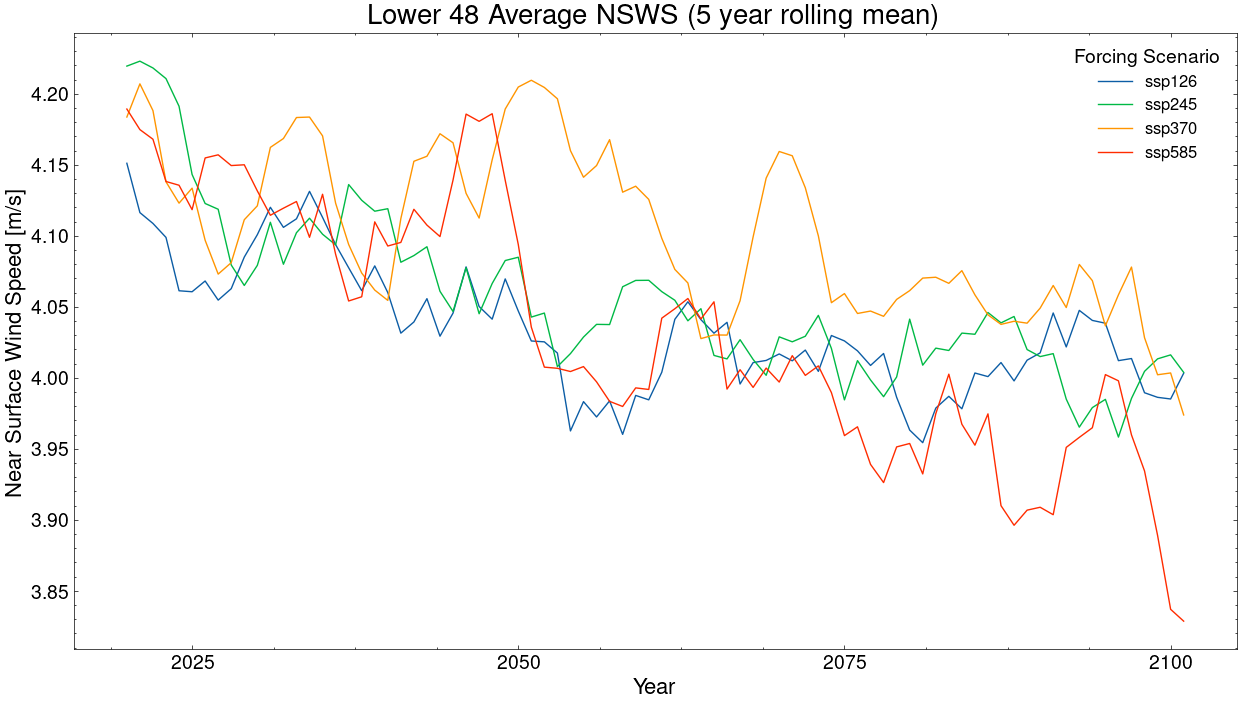

In [4]:
# Figure out nice way to add error bars?
import fig_timeseries
reload(fig_timeseries)
from fig_timeseries import fig_timeseries
fig_timeseries(cesm2)

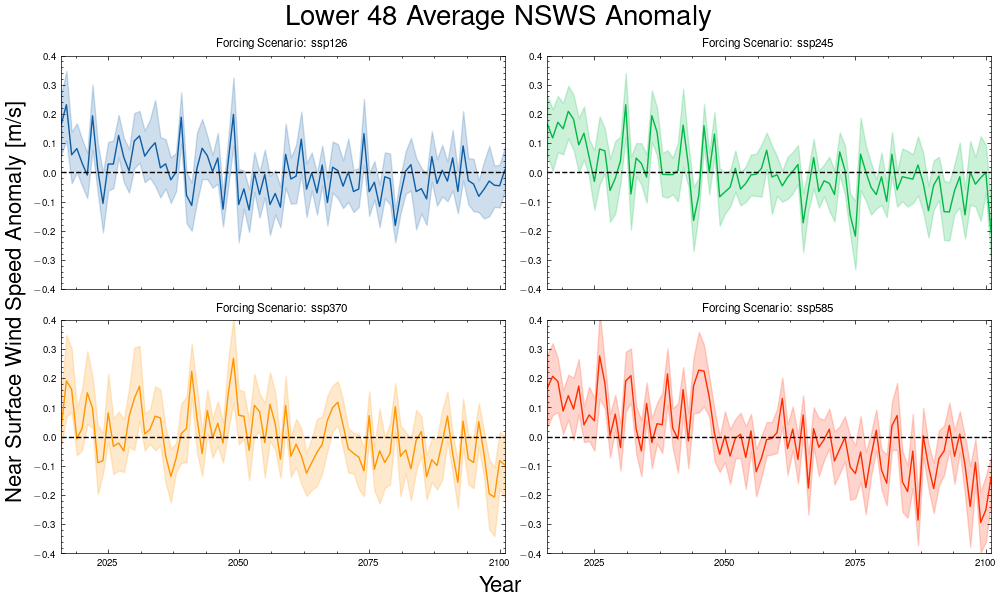

In [5]:
import fig_anomaly
reload(fig_anomaly)
from fig_anomaly import fig_anomaly
fig_anomaly(cesm2)

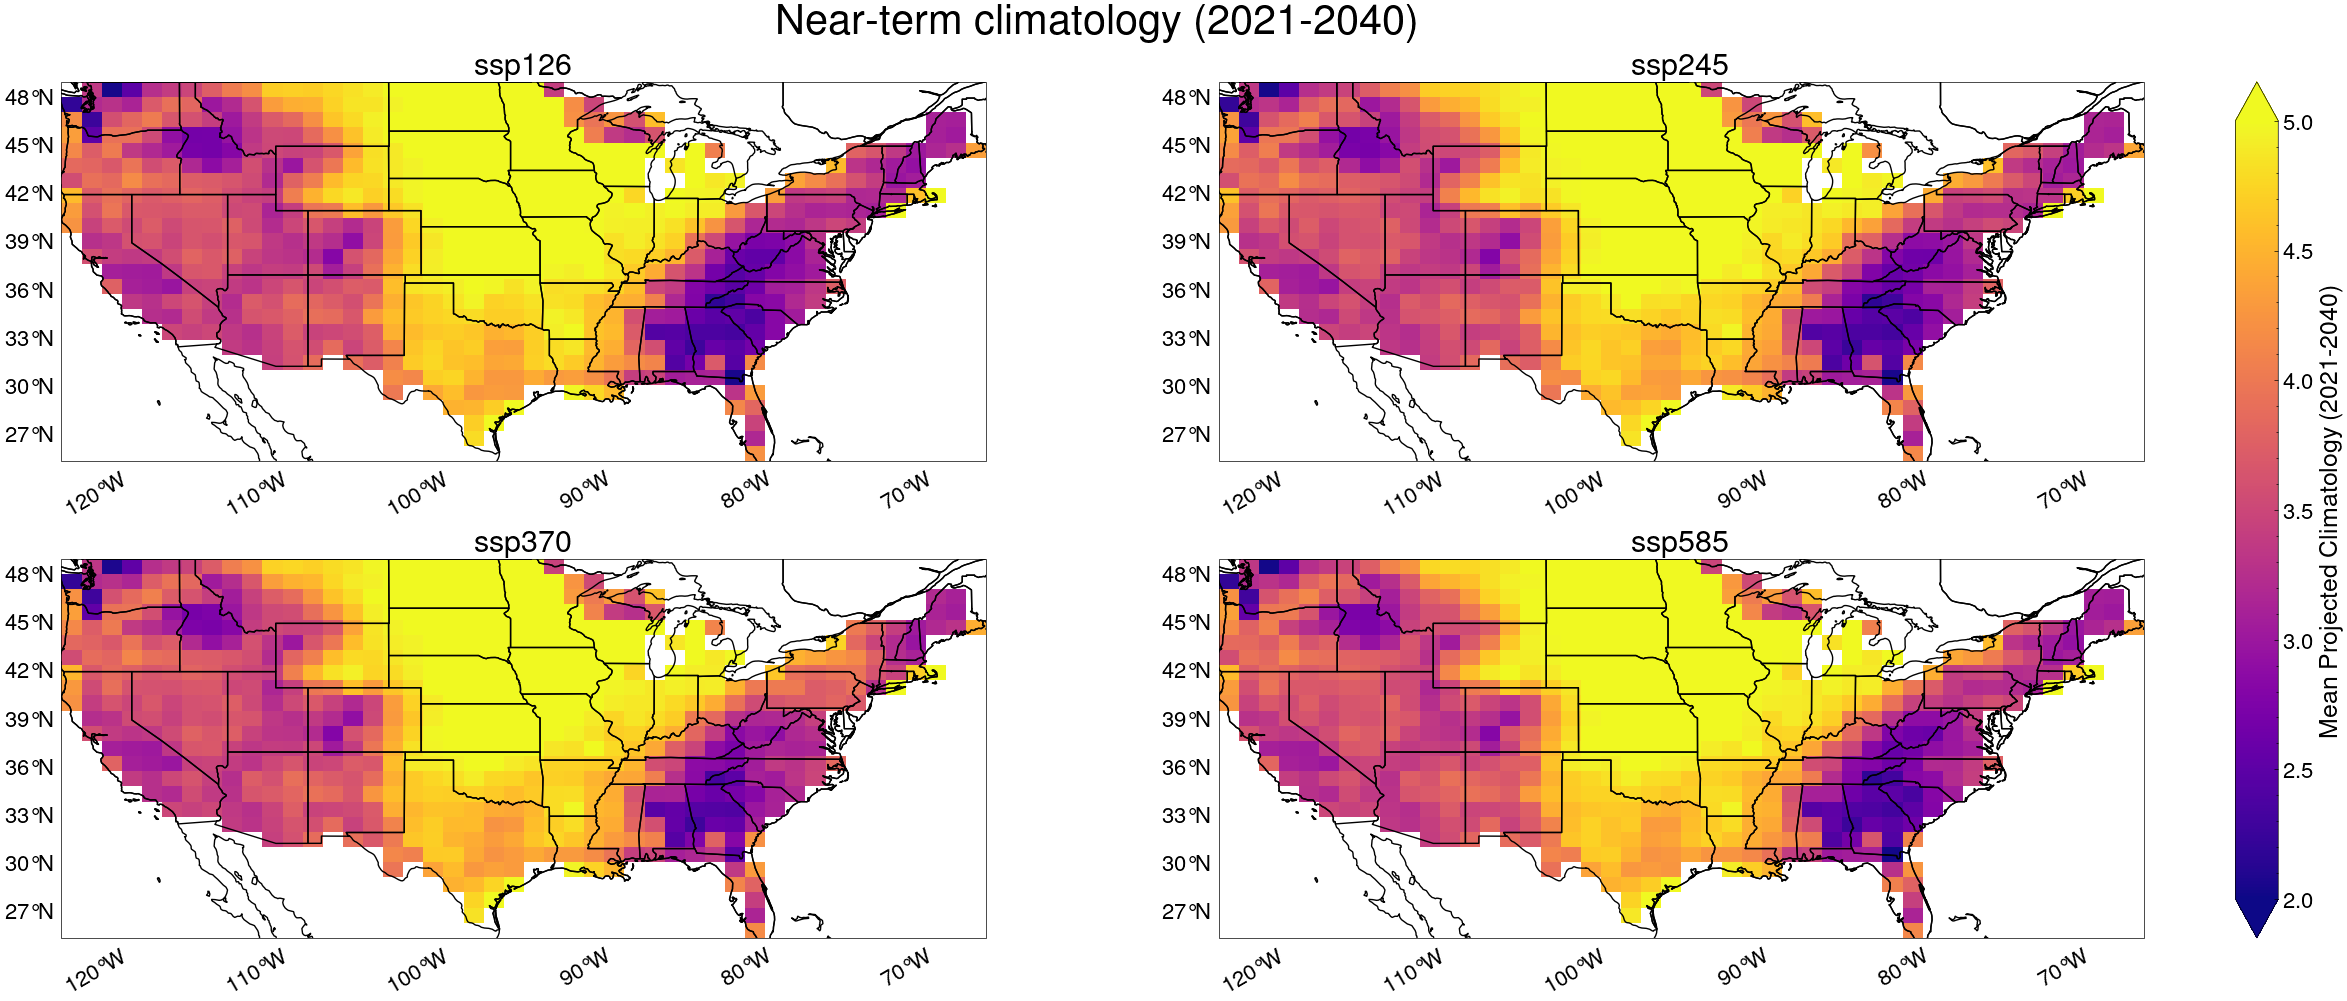

In [9]:
# ADD UNITS TO COLORBAR
import fig_climatology
reload(fig_climatology)
from fig_climatology import fig_climatology
# Shen (2022) uses: 2021–2040 (the “near-term”), 2041–2060 (the “mid-term”), and 2081–2100 (the “long-term”)
fig_climatology(cesm2, period='Near-term')

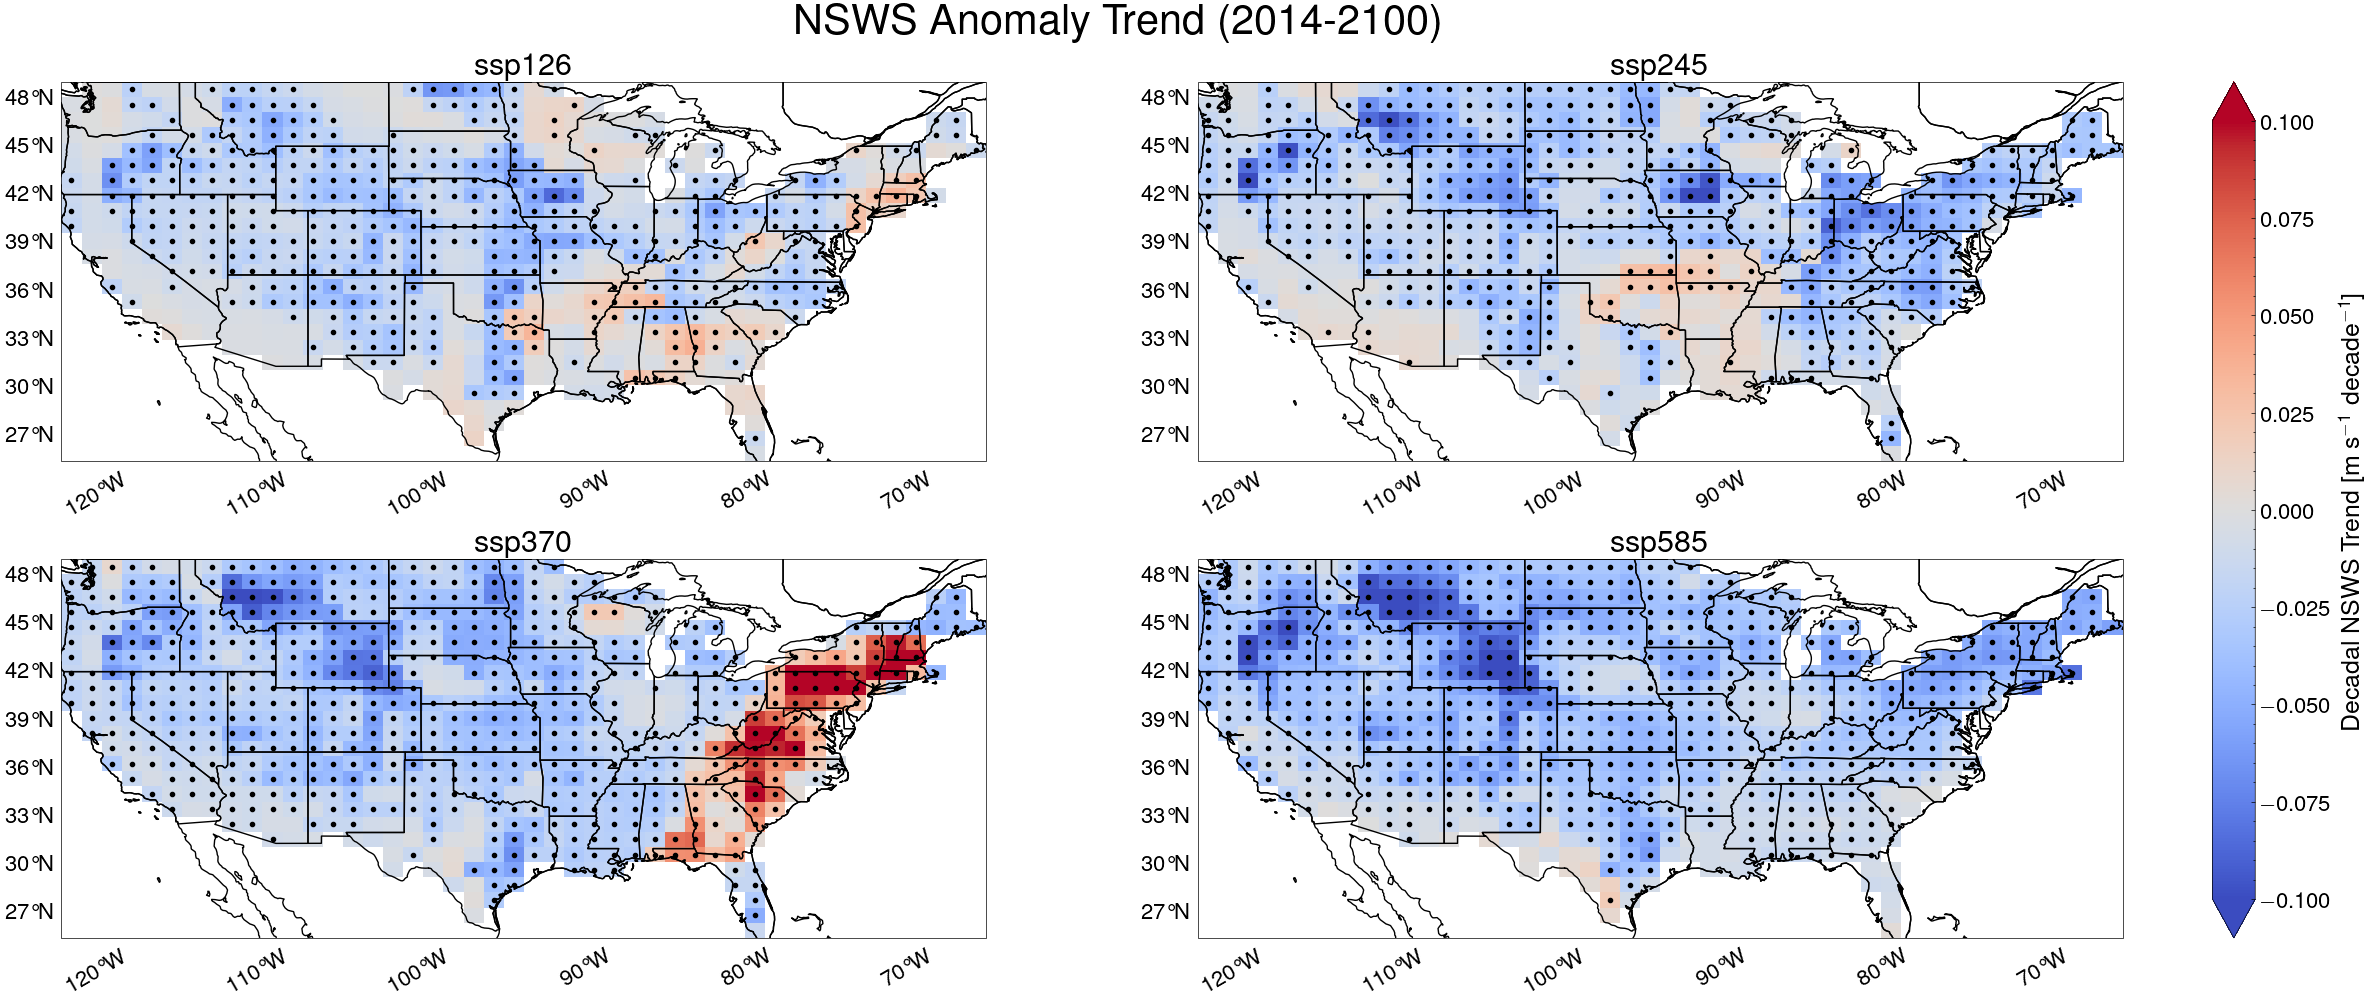

In [7]:
import fig_lineartrend
reload(fig_lineartrend)
from fig_lineartrend import fig_lineartrend
fig_lineartrend(cesm2)

The regression program reports a standard error of the slope. Compute the t ratio as the slope divided by its standard error. Actually, it is (slope minus null hypothesis slope) divided by the standard error, but the null hypothesis slope is nearly always zero.

Now you have a t ratio. The number of degrees of freedom (df) equals the number of data points minus the number of parameters fit by the regression (two for linear regression).

With those values (t and df) you can determine the P value with an online calculator or table.

In [ ]:
from scipy.stats import weibull_min
boston = cesm2['ssp370.weekmax'].sfcWind.sel(lat=42.3601, lon=71.0589, method='nearest')
plt.hist(boston.values.flatten(), bins=50, alpha=0.5, density=True)
shape, loc, scale = weibull_min.fit(boston.values.flatten()) # Can also use floc=0
x = np.linspace(0, 15, 100)
plt.plot(x, weibull_min.pdf(x, shape, loc, scale), 'k-', lw=2, label='frozen pdf')
plt.show()
# Probability of 15 m/s exceedance
prob = weibull_min.pdf(15, shape, loc, scale)
# Probability is in weeks
print(f'Probabilty of exceeding 15 m/s after 50 years is: {prob*52*50:.2}')

In [ ]:
# https://xclim.readthedocs.io/en/stable/notebooks/frequency_analysis.html
from xclim.indices.stats import frequency_analysis
# API: https://xclim.readthedocs.io/en/stable/_modules/xclim/indices/stats.html
boston = cesm2['ssp370.weekmax'].sfcWind.sel(lat=42.3601, lon=71.0589, method='nearest')#.sel(time=slice(None, '2050'))
# Compute the design value
frequency_analysis(
    boston, t=50, dist="genextreme", mode="max", freq='DAYS', method='PWM'
)

In [ ]:
# Calculate and plot Extreme 50 year gust! https://www.wikiwand.com/en/IEC_61400
import fig_50yearmax
reload(fig_50yearmax)
from fig_50yearmax import fig_50yearmax
print("THIS DOESN'T DO 50 YEAR MAX YET")
fig_50yearmax(cesm2)